---

title: "逻辑回归讲解"
date: 2023-04-24
author: 郝鸿涛
slug: lr
draft: false
toc: true
tags: ML

---

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random

## 数据介绍

更多关于 MNIST 数据的介绍请看 [这里](/en/2022/09/26/knn/#introduction-to-mnist-dataset)

In [239]:
file = '../static/files/large/mnist_train.csv'

In [240]:
df = pd.read_csv(file)

In [241]:
df.shape

(59999, 785)

In [242]:
df.head(2)

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [243]:
df.iloc[1,:].max()

255

In [244]:
def data_loader(file):
    df = pd.read_csv(file)
    x = (df.iloc[:, 1:]/255.0).to_numpy()
    y = df.iloc[:, 0].to_numpy()
    return (x, y)

In [245]:
x_train, y_train = data_loader(file)

In [246]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [247]:
y_train

array([0, 4, 1, ..., 5, 6, 8])

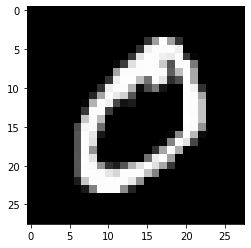

In [248]:
example_to_draw = x_train[0, :].reshape(28,28)
plt.imshow(example_to_draw, cmap='gray')
plt.show()

In [249]:
test_labels = [8, 4]
indices = np.where(np.isin(y_train, test_labels))[0]

x = x_train[indices]
y = y_train[indices]

# 如果数字是 8， 我们把它变成 0
y[y == test_labels[0]] = 0

# 如果数字是 4， 我们把它变成 1
y[y == test_labels[1]] = 1

## 逻辑回归的原理

我们现在来看一下我们想干嘛。`x` 是训练数据，`y` 是我们想要的结果。我们来随便看一个例子：

In [250]:
x.shape, y.shape

# 我们总共有 11693 个例子。x 的每一行是一个数字。

((11693, 784), (11693,))

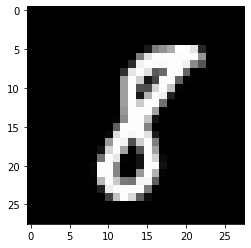

In [251]:
example_to_draw = x[345, :].reshape(28,28)
plt.imshow(example_to_draw, cmap='gray')
plt.show()

# 这是一个 8

我们现在想做的是，我给你一个数字，也就是 x 中的随便一行，你要告诉我这个数字是几。人眼肯定很好识别，但现在我们需要让机器识别数字。

我们注意看。x 的每一行是 784 个像素，每一个像素是一个数值，该数值介于 0 到 1 之间。数值越低，颜色越深。上图中白色部分，数字肯定很高，接近于 1.0。

大体上是这样子：

![](img/lr1.png)

数字除以 255 就是我们想要的样子（虽然维度不同)。

上图[来源](https://observablehq.com/d/01f7c541e3f547f2)

In [252]:
# x[0, :]

那我们一个很正常的想法是，给每一个像素加权。我们现在要识别的是 8 和 4. 当数字是 8 的时候，我们希望最后算出来的结果是 0。是 4 的时候，我们希望算出来的结果是 1. 

那如果你是机器，你怎么办？考虑到写 4 的时候，我们会在左侧写一个竖，靠右侧又写一个竖。那是不是那几个像素我们给它们比较大的加权，这样算出来的结果就比较大（我们之后会讲到，我们要给数值进行转化。结果越大，我们可以让转化后的结果越接近于 1）。我们写 8 的时候，会在中间上侧画一个弧，中间下侧也有一个弧，那是不是那几个像素我们给它们比较小的加权，这样算出的结果就比较小，也就是越接近于 0。

我们来总结一下，每一个要猜的数字，也就是 x 的其中一行，一共有 784 个数，我们给每一个数一个加权值，设为 w。w 是一个 $784 \times 1$ 的向量。除了 w，我们还需要一个数字，即「偏差」(bias)，这个偏差可以当作阀门一样来对加权运算后的结果进行微调。我们的目标是：没有蛀牙。不对，我们的目标是找到这样的 w 和 b，使得对于 x 的每一行（也就是每一个图像），加权运算与偏差调整之后的结果，也就是 $x_i w + b$，正好是 x 该行所显示的数字。也就是说，我们要让结果要么是 0， 要么是 1. 

然而，现在的问题是，$x_i w + b$，并不一定介于 0 与 1 之间，更不要说结果要么是 0， 要么是 1。怎么办？

逻辑回归要登场了。

我们现在来举个例子。我们知道 $w$ 是一个 $784 \times 1$ 的向量，$b$ 是一个数字。我们给它们初始化一下，随便取值：

In [253]:
m = x.shape[1]

w = np.random.rand(m)
b = np.random.rand()

In [254]:
def check_random_pred_result(n):
    """随机抽 n 个在 0 和 len(x)+ 1 之间的整数，比较真实结果和基于 w, b 的预测结果
    """
    rand_idxs = random.sample(range(0, len(x) + 1), n)
    for i in rand_idxs:
        h = x[i, :]@w + b
        a = str(1/(1+np.exp(-h)))
        result = str(y[i])
        print("Actual result is "+ result + ", prediction is " + a)

In [255]:
check_random_pred_result(10)

Actual result is 0, prediction is 1.0
Actual result is 1, prediction is 0.9999999999999629
Actual result is 0, prediction is 0.9999999999999998
Actual result is 0, prediction is 0.9999999999999998
Actual result is 0, prediction is 1.0
Actual result is 0, prediction is 1.0
Actual result is 0, prediction is 1.0
Actual result is 1, prediction is 1.0
Actual result is 1, prediction is 1.0
Actual result is 1, prediction is 1.0


In [256]:
np.log(0.1)

-2.3025850929940455

我们看到，预测总是 1，这说明上面的随机参数 w, b 是没办法帮我们完成任务的。我们要做的是根据真实结果和预测结果，来一步步调整参数，最终让我们的预测结果逼近真实结果。下一个关键问题是如何调整参数。

我们首先需要关注的是真实结果和预测结果的误差。这个误差最简单粗暴的测量方法是两者相减，但这种方法不适合机器学习，我现在还没办法说明为什么。我们通常用的测量方法，也就是我们通常说的「损失函数」(loss function)，是 binary cross entropy。记真实结果为 $a$，预测结果为 $y$，那两者之间的差别我们用 binary cross entropy loss 来测量。

$$L = - (y \cdot log(a) + (1-y)\cdot log(1-a))$$

比如，当结果是 $ y = 0$，预测是 $a = 1$ 的时候，损失是：

$$L = - (0 \cdot log(1) - 1 \cdot log(0.001))$$

这里需要注意的是，$log(0)$ 是无定义的，所以我们算 $log(0.001)$，当然，你算 $log(0.1)$, $log(0.01)$ 等等都没什么问题。

更多关于 cross entropy loss 的知识，可以看[这里](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e)。关于 entropy，你可以看我写的[一篇科普](/en/2022/09/21/entropy/)。

算出损失函数并不是目的，我们的目的是调整参数 $w$ 和 $b$，让每一次算出来的损失函数变小，也就是让预测结果逼近真实结果。所以我们的最终结果，是让损失函数变小。这是一个典型的优化问题。我们需要给 $L$ 求导。

要给 $L$ 求导，我们先来回顾一下 $a$ 是怎么算出来的。根据上面的 `check_random_pred_result` 这个函数，我们可知：

$$a = \frac{1}{1 + e^{-h}}$$

$$h = w^T \cdot x + b$$

其中 $x$ 是一个数字的图像，也就是一个 $784 \times 1$ 的矩阵。

根据 chain rule，我们可知：

$$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial a} \cdot \frac{\partial a}{\partial h} \cdot \frac{\partial h}{\partial w}$$

根据微积分运算法则，我们知道：

$$\frac{\partial L}{\partial a} = \frac{a - y}{a (1-a)}$$

(如果上面这个你不知道是为啥，请看[这里](/en/2022/11/28/log-derivative/))。

$$\frac{\partial a}{\partial h} = a(1-a)$$

(如果上面这个你不知道是为啥，请看[这里](/en/2022/10/30/sigmoid-derivative/))。

$$\frac{\partial h}{\partial w} = x$$

所以，

$$\frac{\partial L}{\partial w} = x(a-y)$$

以上运算过程参考 [Giang 的一篇帖子](https://math.stackexchange.com/a/3220477).

如果你学过微积分，你会知道，$L(w)$ 函数上的每一个点，其斜率是 $x(a-y)$。我们想让 $L(w)$ 最小，也就是想让其斜率变成零。需要做的是朝着斜率 $x(a-y)$ **相反**的方向走就好。

![](https://editor.analyticsvidhya.com/uploads/2260058912gradient%20decent.jpg)

上图[来源](https://editor.analyticsvidhya.com/uploads/2260058912gradient%20decent.jpg)


朝这个方向走迈的步子我们叫做 $\alpha$。

我们算了 $\frac{\partial L}{\partial w}$，但还没有算 $\frac{\partial L}{\partial b}$:

同样根据 chain rule，我们可知：

$$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial a} \cdot \frac{\partial a}{\partial h} \cdot \frac{\partial h}{\partial b}$$

因为

$$\frac{\partial h}{\partial b} = 1$$

所以

$$\frac{\partial L}{\partial b} = a-y$$

## 逻辑回归的代码实现

In [257]:
epochs = 20
alpha = 0.001
loss_prev = 10e6

w = np.random.rand(m)
b = np.random.rand()

for epoch in range(epochs):
    # x: n * 784, w: 784 * 1, b: 1
    # h: n * 1
    a = x@w + b
    
    # a: n * 1
    a = 1/(1+np.exp(-a))
    
    # 避免 log(0) 的情况
    a = np.clip(a, .001, .999)
    
    # y: n * 1, a - y: n * 1, x.T: 784 * n
    # w: 784 * 1
    w -= alpha * (x.T)@(a-y)
    
    # 所有数据针对 b 的梯度下降取平均值
    b -= alpha * np.mean(a - y)
    
    loss = - np.sum(y*np.log(a) + (1-y)*np.log(1-a))
    loss_reduction = loss_prev - loss
    loss_prev = loss
    
    accuracy = sum((a > 0.5).astype(int) == y)/len(y)
    
    print('第', epoch+1, '轮', ' 损失为 {:.7}'.format(loss), \
          ' 该轮中损失减少了 {:.7}'.format(loss_reduction), \
          ' 正确识别率为 {:.4%}'.format(accuracy)
         )

第 1 轮  损失为 40423.12  该轮中损失减少了 9.959577e+06  正确识别率为 49.9615%
第 2 轮  损失为 40360.96  该轮中损失减少了 62.16079  正确识别率为 50.0385%
第 3 轮  损失为 4434.966  该轮中损失减少了 35925.99  正确识别率为 93.5089%
第 4 轮  损失为 3753.831  该轮中损失减少了 681.1356  正确识别率为 94.4839%
第 5 轮  损失为 2997.665  该轮中损失减少了 756.1655  正确识别率为 95.4674%
第 6 轮  损失为 2635.214  该轮中损失减少了 362.4509  正确识别率为 95.9634%
第 7 轮  损失为 2308.995  该轮中损失减少了 326.219  正确识别率为 96.3910%
第 8 轮  损失为 2072.306  该轮中损失减少了 236.6893  正确识别率为 96.7331%
第 9 轮  损失为 1862.94  该轮中损失减少了 209.3665  正确识别率为 97.0581%
第 10 轮  损失为 1712.142  该轮中损失减少了 150.7973  正确识别率为 97.2291%
第 11 轮  损失为 1589.948  该轮中损失减少了 122.1944  正确识别率为 97.3745%
第 12 轮  损失为 1488.339  该轮中损失减少了 101.6084  正确识别率为 97.5199%
第 13 轮  损失为 1398.682  该轮中损失减少了 89.65783  正确识别率为 97.6653%
第 14 轮  损失为 1321.616  该轮中损失减少了 77.0652  正确识别率为 97.8107%
第 15 轮  损失为 1253.288  该轮中损失减少了 68.32872  正确识别率为 97.9560%
第 16 轮  损失为 1194.084  该轮中损失减少了 59.20371  正确识别率为 98.0672%
第 17 轮  损失为 1142.404  该轮中损失减少了 51.68004  正确识别率为 98.1955%
第 18 轮  损失为 1097.171  该轮中损失减少了 45.23287

## 检测

In [258]:
x_test, y_test = data_loader('../static/files/large/mnist_test.csv')
test_labels = [8, 4]
indices = np.where(np.isin(y_test, test_labels))[0]

x = x_test[indices]
y = y_test[indices]

# 如果数字是 8， 我们把它变成 0
y[y == test_labels[0]] = 0

# 如果数字是 4， 我们把它变成 1
y[y == test_labels[1]] = 1

In [259]:
h = x@w + b
a = 1/(1+np.exp(-h))
accuracy = sum((a > 0.5).astype(int) == y)/len(y)
print(' 正确识别率为 {:.4%}'.format(accuracy))

 正确识别率为 98.7219%
